In [1]:
from torch.utils.data import Dataset,DataLoader
from torchvision.transforms import transforms
import pickle
import torch
from diffusers import (
    AutoencoderKL,
    DDPMScheduler,
    StableDiffusionInpaintPipeline,
    StableDiffusionPipeline,
    UNet2DConditionModel,
)
import torch.nn.functional as F
import wandb
from tqdm import tqdm
import numpy as np
import cv2
import gc
from transformers import CLIPTextModel, CLIPTokenizer
import bitsandbytes as bnb

In [2]:
class HcInpaintDataset(Dataset):
    def ct_transform(self,ct):
        transform = transforms.Compose([
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])
        tensor = transform(ct)

        return tensor


    def __init__(self,data_path,tokenizer,ct_transform=False):
        super().__init__()
        with open(data_path,'rb') as file:
            dataset = pickle.load(file) # 不加self. 节省内存？

        self.origin_imgs = dataset['pixel values']
        self.prompts = dataset['class labels']
        self.masks = dataset['mask labels']

        self.ct_transform = ct_transform if ct_transform != False else transforms.Lambda(lambda x: x)

        self.tokenizer = tokenizer

        
    def __len__(self):
        return len(self.origin_imgs)
    
    def __getitem__(self, index): # 返回一次取出的数据 试试直接用batch
        example = {}

        origin_img = self.origin_imgs[index] #(512,512 float32)
        mask = self.masks[index].to(torch.float32) #(512,512 uint8)
        input_id = self.tokenizer(self.prompts[index],
                                  max_length=20,
                                  padding="max_length",
                                  truncation=True,
                                  return_tensors="pt").input_ids

        masked_img = origin_img * (mask<0.5)

        example["masked_img"] = self.ct_transform(torch.stack([masked_img] * 3, dim=0))
        example["origin_img"] = self.ct_transform(torch.stack([origin_img] * 3, dim=0))
        example["mask"] = mask.view(1,512,512)
        example["input_id"] = input_id
        example["prompt"] = self.prompts[index]

        return example

In [3]:
device = "cuda"
pretrained_model_name_or_path = "/root/autodl-tmp/stabilityai/stable-diffusion-2-inpainting"
weight_dtype = torch.float32



noise_scheduler = DDPMScheduler.from_pretrained(pretrained_model_name_or_path, subfolder="scheduler")
tokenizer = CLIPTokenizer.from_pretrained(
    pretrained_model_name_or_path,
    subfolder="tokenizer"
)
text_encoder = CLIPTextModel.from_pretrained(
    pretrained_model_name_or_path,
    subfolder="text_encoder"
).to(device, dtype=weight_dtype)
vae = AutoencoderKL.from_pretrained(
    pretrained_model_name_or_path,
    subfolder="vae"
).to(device, dtype=weight_dtype)
unet = UNet2DConditionModel.from_pretrained(
    pretrained_model_name_or_path,
    subfolder="unet"
).to(device, dtype=weight_dtype)

pipe = StableDiffusionInpaintPipeline.from_pretrained(pretrained_model_name_or_path,
                                                      vae=vae,
                        text_encoder=text_encoder,
                        tokenizer=tokenizer,
                        unet=unet,
                        torch_dtype=weight_dtype).to(device)

/root/miniconda3/envs/diffusers/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [4]:
train_dataset = HcInpaintDataset(data_path= "/root/autodl-tmp/dataset/train_HC_dataset.pkl",tokenizer=tokenizer,ct_transform=False)
log_dataset = HcInpaintDataset(data_path= "/root/autodl-tmp/dataset/val_HC_dataset.pkl",tokenizer=tokenizer,ct_transform=False)

train_loader = DataLoader(dataset=train_dataset,batch_size=1, shuffle=True)

/root/miniconda3/envs/diffusers/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


In [5]:
H,W = (512,512)
NUM_TRAIN_TIMESTEPS = 1000
NUM_TRAIN_EPOCHS = 1
LR = 5e-6
NUM_INFER_STEPS=20
GUIDANCE_SCALE = 7.5

visible_index = [5]  # 选择的索引

In [6]:
optimizer = bnb.optim.AdamW8bit(unet.parameters(), lr=LR)


for epoch in range(0, NUM_TRAIN_EPOCHS):
    unet.train()
    
    for _, batch in tqdm(enumerate(train_loader, start=1), 
                     desc=f'(epoch:{epoch}/{NUM_TRAIN_EPOCHS})', 
                     total=len(train_loader), 
                     leave=True):
        
        optimizer.zero_grad()

        latents = vae.encode(batch["origin_img"].to(device,dtype=weight_dtype)).latent_dist.sample()
        latents = latents * vae.config.scaling_factor

        masked_latents = vae.encode(batch["masked_img"].to(device,dtype=weight_dtype)).latent_dist.sample()
        masked_latents = masked_latents * vae.config.scaling_factor

        masks = batch["mask"].to(device,dtype=weight_dtype)

        resized_masks = F.interpolate(masks, size=(64, 64))

        # 加入噪声
        noise = torch.randn_like(latents)
        bs = latents.shape[0]

        # 创建timesteps
        timesteps = torch.randint(0,NUM_TRAIN_TIMESTEPS,(bs,),device=device).long()

        noisy_latents = noise_scheduler.add_noise(latents,noise,timesteps)

        # 沿着channel拼接
        latent_model_input = torch.cat([noisy_latents,masked_latents,resized_masks],dim=1)

        encoder_hidden_states = text_encoder(batch["input_id"].to(device))[0]

        # loss
        noise_pred = unet(latent_model_input, timesteps, encoder_hidden_states).sample

        loss = F.mse_loss(noise_pred.float(), noise.float(), reduction="mean")

        loss.backward()
        optimizer.step()
        
        # wandb.log({'train_step_loss': loss})

    # log
    unet.eval()
    for i in visible_index:
        # 获取图片和mask
        init_img = (log_dataset[i]["origin_img"] + 1) / 2
        init_img = init_img.to(device)
        mask = log_dataset[i]["mask"].to(device)
        
        pipe.unet = unet
        result = pipe(
            prompt=log_dataset[i]["prompt"],
            image=init_img,
            mask_image=mask,
            num_inference_steps=NUM_INFER_STEPS,
            guidance_scale=GUIDANCE_SCALE,
        ).images[0]

        init_img_np = (init_img.cpu() * 255).permute(1, 2, 0).numpy().astype('uint8').copy()
        result_np = np.array(result).astype('uint8').copy()

        mask = mask.cpu().numpy().squeeze().astype('uint8')
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(init_img_np, contours, -1, (255,0,0), 1)
        cv2.drawContours(result_np, contours, -1, (255,0,0), 1)


(epoch:0/1): 100%|██████████| 643/643 [04:16<00:00,  2.50it/s]
/root/miniconda3/envs/diffusers/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `vae_latent_channels` directly via 'VaeImageProcessor' object attribute is deprecated. Please access 'vae_latent_channels' over 'VaeImageProcessor's config object instead, e.g. 'scheduler.config.vae_latent_channels'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


  0%|          | 0/20 [00:00<?, ?it/s]

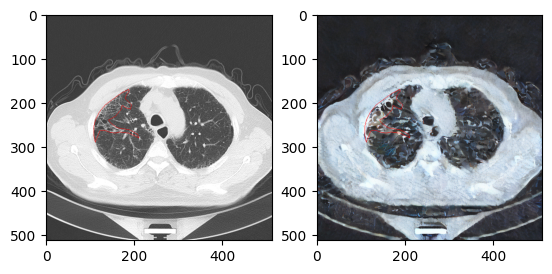

In [7]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,2)
ax[0].imshow(init_img_np)
ax[1].imshow(result_np)